In [ ]:
# !pip install -q git+https://github.com/matjesg/deepflash2.git

In [ ]:
# !pip install zarr

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
# imports
import zarr, cv2
import numpy as np, pandas as pd, segmentation_models_pytorch as smp
from deepflash2.all import *
from deepflash2.transforms import random_center
import albumentations as alb
import torch
import torch.nn as nn

In [4]:
from config.global_vars import *
from datasets.hubdataset import HubDataset

In [5]:
ARCH = 'unet'

In [6]:
# Model
model = smp.Unet(encoder_name=ENCODER_NAME, 
                 encoder_weights=ENCODER_WEIGHTS, 
                 in_channels=CHANNELS, 
                 classes=CLASSES)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.cuda();

In [7]:
from fastai.vision.all import *

In [8]:
@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [9]:
@patch
def __getitem__(self:RandomTileDataset, idx):
    idx = idx % len(self.files)
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = self.files[idx]
    img = self.read_img(img_path, divide=self.divide)
    n_channels = img.shape[-1]

    lbl, pdf  = self.labels[img_path.name], self.pdfs[self._name_fn(img_path.name)]
    center = random_center(pdf[:], lbl.shape, TILE_SHAPE)
    X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
    Y = self.deformationField.apply(lbl, center, self.padding, 0)
    X1 = X.copy()

    if self.albumentations_tfms:
        augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
        X = (augmented['image']/255)
        Y = augmented['mask']

    X = X.transpose(2, 0, 1).astype('float32')
    Y = Y.astype('int64')

    if self.loss_weights:
        _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
        return  TensorImage(X), TensorMask(Y), torch.Tensor(W)
    else:
        return  TensorImage(X), TensorMask(Y)

In [10]:
@patch
def _do_one_batch(self:Learner):
    self.pred = self.model(*self.xb)
    self('after_pred')
    if len(self.yb):
        self.loss_grad = self.loss_func(self.pred, *self.yb)
        self.loss = self.loss_grad.clone()
    self('after_loss')
    if not self.training or not len(self.yb): return
    self('before_backward')
    self.loss_grad.backward()
    self._with_events(self.opt.step, 'step', CancelStepException)
    self.opt.zero_grad()

### Configuration

In [11]:
class CONFIG():
    
    # data paths
    data_path = Path('/home/jupyter/data_2/')
    data_path_zarr = Path('/home/jupyter/train_scale2')
    mask_preproc_dir = '/home/jupyter/masks_scale2'
    
    # deepflash2 dataset
    # scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    scale = 1 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (TILE_SHAPE, TILE_SHAPE)
    padding = (0,0) # Border overlap for prediction
    n_jobs = NUM_WORKERS
    sample_mult = 200 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)

    # pytorch model (segmentation_models_pytorch)
    encoder_name = ENCODER_NAME
    encoder_weights = ENCODER_WEIGHTS
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 6
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1)
    metrics = [Iou(), Dice_f1()]
    optimizer = ranger
    max_learning_rate = 1e-3
    epochs = 15
    
cfg = CONFIG()

In [12]:
# Albumentations augmentations
# Inspired by https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter
# deepflash2 augmentations are only affine transformations
tfms = alb.OneOf([
    alb.HueSaturationValue(10,15,10),
    alb.CLAHE(clip_limit=2),
    alb.RandomBrightnessContrast(),
    alb.OneOf([
        alb.MotionBlur(p=0.2),
        alb.MedianBlur(blur_limit=3, p=0.1),
        alb.Blur(blur_limit=3, p=0.1),
    ], p=0.2)
], p=0.3)

In [13]:
df_train = pd.read_csv(cfg.data_path/'train.csv')
df_info = pd.read_csv(cfg.data_path/'HuBMAP-20-dataset_information.csv')

files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')]
label_fn = lambda o: o

In [14]:
!ls {cfg.mask_preproc_dir}

labels	pdfs


### Training

In [15]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

train_ds = RandomTileDataset(files, label_fn=label_fn, **ds_kwargs)
valid_ds = TileDataset(files, label_fn=label_fn, **ds_kwargs, is_zarr=True)

Using preprocessed masks from /home/jupyter/masks_scale2
Using preprocessed masks from /home/jupyter/masks_scale2


In [16]:
root_dir = cfg.data_path
slices_path = SLICES_PATH
transform = alb.Compose([
        alb.Resize(TILE_SHAPE, TILE_SHAPE, p=1.0),
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.RandomRotate90(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        alb.OneOf([
            alb.OpticalDistortion(p=0.4),
            alb.GridDistortion(p=.1, border_mode=cv2.BORDER_REFLECT),
            alb.IAAPiecewiseAffine(p=0.4),
        ], p=0.3),
        alb.OneOf([
            alb.MotionBlur(p=0.2),
            alb.MedianBlur(blur_limit=3, p=0.1),
            alb.Blur(blur_limit=3, p=0.1),
        ]),
        alb.OneOf([
            alb.HueSaturationValue(10,15,10),
            alb.CLAHE(clip_limit=3),
            alb.RandomBrightnessContrast(),
            alb.RandomGamma()
        ], p=0.5)
    ], p=1.0)
window = WINDOW
overlap = OVERLAP
threshold = THRESHOLD
ds_2_kwargs = {
    'mode': 'train',
    'valid_transform': None,
    'shifting': False,
    'rebuild_slices': False
}

train_ds_2 = HubDataset(root_dir, slices_path, transform, window, overlap, threshold, **ds_2_kwargs)

Reading cached slices, files and masks


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [17]:
train_ds_2

total: 2338, skipped: 0 mode: train

In [18]:
image, mask = train_ds[0]

In [19]:
image.shape, mask.shape

(torch.Size([3, 768, 768]), torch.Size([768, 768]))

In [20]:
image, mask = train_ds_2[0]

In [21]:
image.shape, mask.shape, mask.dtype

(torch.Size([3, 768, 768]), torch.Size([1, 768, 768]), torch.int64)

In [22]:
# Dataloader and learner
dls = DataLoaders.from_dsets(train_ds_2, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
if torch.cuda.is_available(): dls.cuda(), model.cuda()
# cbs = [SaveModelCallback(monitor='iou'), ElasticDeformCallback]
cbs = [SaveModelCallback(monitor='iou')]
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()

epoch,train_loss,valid_loss,iou,dice_f1,time
0,0.265953,0.201913,0.778552,0.875490,07:38
1,0.042062,0.016037,0.835664,0.910476,07:29
2,0.028031,0.017509,0.773178,0.872082,07:29
3,0.025476,0.006907,0.868902,0.929853,07:28
4,0.024258,0.008150,0.850548,0.919239,07:29
5,0.023788,0.007795,0.859970,0.924714,07:29
6,0.018579,0.006862,0.870507,0.930771,07:27
7,0.018751,0.006403,0.868582,0.929670,07:28
8,0.020413,0.005886,0.891091,0.942410,07:28
9,0.017748,0.005901,0.881744,0.937156,07:29


Better model found at epoch 0 with iou value: 0.7785524627166854.
Better model found at epoch 1 with iou value: 0.8356642944936421.
Better model found at epoch 3 with iou value: 0.8689021287776502.
Better model found at epoch 6 with iou value: 0.8705065627607955.
Better model found at epoch 8 with iou value: 0.8910911708091406.
Better model found at epoch 11 with iou value: 0.8973774162642932.


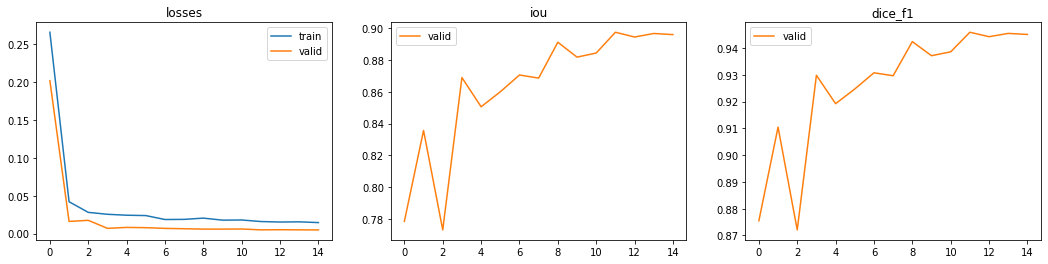

In [23]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

In [24]:
!cp models/model.pth models/hubmap_simple_training_{ARCH}_{ENCODER_NAME}_b{cfg.batch_size}.pth

In [32]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
if torch.cuda.is_available(): dls.cuda(), model.cuda()
cbs = [SaveModelCallback(monitor='iou'), ElasticDeformCallback]
learn = Learner(dls, learn.model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()

epoch,train_loss,valid_loss,iou,dice_f1,time
0,0.013637,0.004663,0.904237,0.949711,09:29
1,0.010640,0.004683,0.902132,0.948548,09:29
2,0.012675,0.005301,0.894320,0.944212,09:29
3,0.012779,0.006296,0.876271,0.934056,09:29
4,0.012244,0.005619,0.890313,0.941974,09:29
5,0.013025,0.005568,0.891469,0.942621,09:29
6,0.012576,0.005406,0.886041,0.939578,09:30
7,0.011248,0.005218,0.896266,0.945296,09:29
8,0.010952,0.005048,0.898342,0.946449,09:30
9,0.010763,0.005389,0.891170,0.942454,09:30


Better model found at epoch 0 with iou value: 0.9042369571742669.
Better model found at epoch 12 with iou value: 0.9048007097048307.


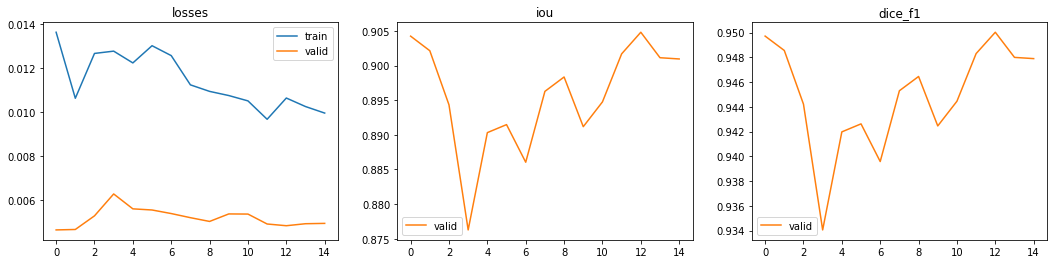

In [33]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

In [34]:
!mv models/model.pth models/hubmap_pdf_{ARCH}_{ENCODER_NAME}_b{cfg.batch_size}.pth